In [1]:
'''
This code will provide a broad analysis of retirement of an individual given some parameters.

description of variables:

k: fração do salário anual [0,1]
A: renda anual de aposentadoria (R$)
i: taxa de juros no período de acumulação (%)
r: taxa de juros no período de aposentadoria (%)
n: tempo de acumulação (int)
m: tempo de aposentadoria (int)
sal: salário anual (R$)
x_0: idade atual (int)
x_1: idade de aposentadoria (int)
x_omega: idade de morte (int)
C: capital investido anualmente (R$)
M: Montante acumulado (R$)
PV: valor presente (R$)
'''

# Import libraries needed for plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set nicer plotting style
plt.style.use('ggplot')
sns.set_theme()

In [2]:
def FVanuidadeordinaria(k,i, n, sal):
    # Cálculo do capital investido anualmente
    C = k * sal

    # Cálculo do capital acumulado na aposentadoria
    M = C * (((1 + i) ** n - 1) / i)
    return M

def planoaposentadoria(A, i, r, sal, x_0, x_1, x_omega):
    n = abs(x_1 - x_0)  # Tempo de acumulação
    m = abs(x_omega - x_1)  # Tempo de aposentadoria
    # Quando M = PV, o capital acumulado é igual ao valor presente
    k = ((A*i)/(sal*r))*((1 - (1+r)**-m)/((1+i)**n - 1))
    return k

def calculaMontanteNecessario(A, r, m):
    # Calcula o montante necessário para garantir a renda A por exatamente m anos
    # com depleção total exatamente no final do período m
    PV = A * (((1 - (1 + r) ** -m) / r))
    return PV

def calculaKExato(A, i, r, sal, x_0, x_1, x_omega):
    n = abs(x_1 - x_0)  # Tempo de acumulação
    m = abs(x_omega - x_1)  # Tempo de aposentadoria
    
    # Primeiro, calculamos o montante necessário para atingir x_omega exatamente
    montante_necessario = calculaMontanteNecessario(A, r, m)
    
    # Depois, calculamos o k necessário para atingir esse montante
    C_necessario = montante_necessario * i / ((1 + i) ** n - 1)
    k = C_necessario / sal
    
    return k



In [3]:
# Create visualizations for accumulation and distribution phases

def plot_retirement_phases(k, i, r, sal, x_0, x_1, x_omega, A):
    # Calculate years for each phase
    accumulation_years = x_1 - x_0
    distribution_years = x_omega - x_1
    
    # Create year ranges for both phases
    accumulation_age_range = list(range(x_0, x_1 + 1))
    distribution_age_range = list(range(x_1, x_omega + 1))
    
    # Calculate yearly investment amount
    C = k * sal
    
    # Initialize arrays to store values for each year
    accumulation_values = []
    yearly_contributions = []
    distribution_values = []
    
    # Calculate accumulation phase values
    current_value = 0
    for year in range(accumulation_years + 1):
        accumulation_values.append(current_value)
        yearly_contributions.append(C)
        if year < accumulation_years:  # Don't add contribution after final year
            current_value = current_value * (1 + i) + C
    
    # Calculate theoretical final value needed
    theoretical_final_value = calculaMontanteNecessario(A, r, distribution_years)
    print(f"Montante teórico necessário para depleção exata: R${theoretical_final_value:.2f}")
    print(f"Montante real acumulado: R${current_value:.2f}")
    
    # Calculate distribution phase values
    remaining_value = accumulation_values[-1]  # Start with final accumulated amount
    depletion_age = None  # Initialize variable to track when funds are depleted
    
    for year in range(distribution_years + 1):
        distribution_values.append(remaining_value)
        if year < distribution_years:  # Don't subtract after final year
            # MODIFIED: First grow the investment, THEN withdraw income (theoretical method)
            remaining_value = remaining_value * (1 + r) - A
            # Check if funds are depleted
            if remaining_value <= 0 and depletion_age is None:
                depletion_age = distribution_age_range[year + 1]  # Age when funds run out
                remaining_value = 0
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot accumulation phase
    ax1.plot(accumulation_age_range, accumulation_values, 'b-', linewidth=2, label='Accumulated Capital')
    ax1.bar(accumulation_age_range[:-1], yearly_contributions[:-1], alpha=0.3, label='Yearly Contribution')
    ax1.set_title('Accumulation Phase', fontsize=14)
    ax1.set_xlabel('Age', fontsize=12)
    ax1.set_ylabel('Amount (R$)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add text annotations for key metrics
    final_amount = accumulation_values[-1]
    total_contributed = sum(yearly_contributions)
    ax1.annotate(f'Final Amount: R${final_amount:.2f}\n'
                 f'Total Contributed: R${total_contributed:.2f}\n'
                 f'Investment Returns: R${final_amount - total_contributed:.2f}',
                 xy=(0.05, 0.85), xycoords='axes fraction',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))
    
    # Plot distribution phase
    ax2.plot(distribution_age_range, distribution_values, 'g-', linewidth=2, label='Remaining Capital')
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.7)
    
    # Add retirement income as bars
    retirement_income = [A] * distribution_years
    retirement_income.append(0)  # No income after last year
    ax2.bar(distribution_age_range, retirement_income, alpha=0.3, label='Annual Retirement Income')
    
    ax2.set_title('Distribution Phase', fontsize=14)
    ax2.set_xlabel('Age', fontsize=12)
    ax2.set_ylabel('Amount (R$)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add annotation showing depletion point or remaining balance
    zero_crosses = np.where(np.array(distribution_values) <= 0)[0]
    if len(zero_crosses) > 0:
        depletion_year = distribution_age_range[zero_crosses[0]]
        ax2.annotate(f'Funds depleted at age {depletion_year}',
                     xy=(depletion_year, 0), xytext=(depletion_year-10, max(distribution_values)/4),
                     arrowprops=dict(facecolor='red', shrink=0.05))
    else:
        remaining = distribution_values[-1]
        ax2.annotate(f'Ending balance: R${remaining:.2f}',
                    xy=(distribution_age_range[-1], remaining),
                    xytext=(distribution_age_range[-15], remaining*1.1),
                    arrowprops=dict(facecolor='green', shrink=0.05))
    
    # Print depletion age information
    if depletion_age is not None:
        print(f"\nFundos serão esgotados aos {depletion_age} anos de idade.")
    else:
        print(f"\nFundos não serão esgotados antes dos {x_omega} anos de idade.")
        
    plt.tight_layout()
    plt.show()
    
    # Return the summary data
    return {
        'final_accumulation': final_amount,
        'total_contributed': total_contributed,
        'investment_returns': final_amount - total_contributed,
        'distribution_phase_ending': distribution_values[-1],
        'depletion_age': depletion_age
    }


Fração do salário anual a ser investida (para depleção exata no x_omega): 64.57%
Montante teórico necessário para depleção exata: R$857954.32
Montante real acumulado: R$857954.32

Fundos serão esgotados aos 100 anos de idade.


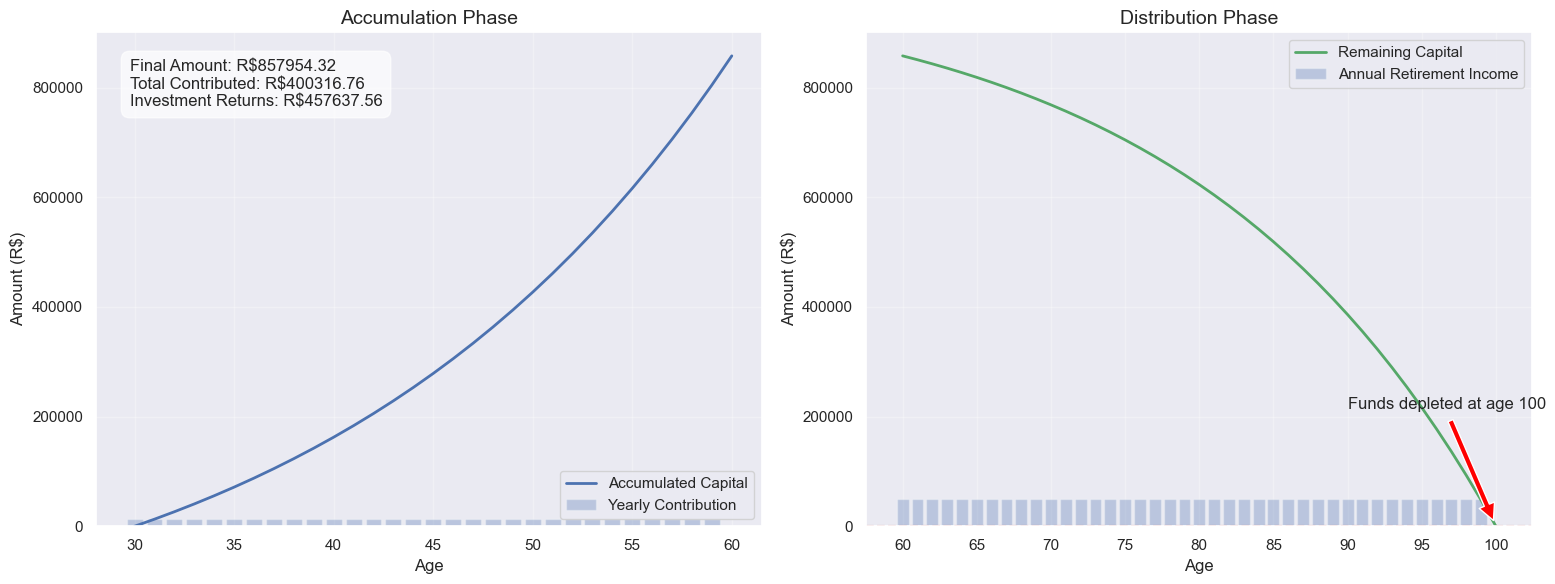


Resumo:
Capital acumulado ao se aposentar: R$857954.32
Total contribuído durante fase de acumulação: R$400316.76
Retorno dos investimentos: R$457637.56
Saldo final após período de distribuição: R$0.00
Idade de esgotamento dos fundos: 100 anos


In [4]:
# Run the visualization with the parameters from the example
i = 0.05  # taxa de juros no período de acumulação (5%)
r = 0.05  # taxa de juros no período de aposentadoria (5%)
sal = 20000  # salário anual (R$)
x_0 = 30  # idade atual (anos)
x_1 = 60  # idade de aposentadoria (anos)
x_omega = 100  # idade de morte (anos)
A = 50000  # renda anual de aposentadoria (R$)

# Calculate k using our optimized function to ensure funds are depleted at x_omega
k = calculaKExato(A, i, r, sal, x_0, x_1, x_omega)
print(f"Fração do salário anual a ser investida (para depleção exata no x_omega): {k:.2%}")

# Run the visualization function
results = plot_retirement_phases(k, i, r, sal, x_0, x_1, x_omega, A)
print("\nResumo:")
print(f"Capital acumulado ao se aposentar: R${results['final_accumulation']:.2f}")
print(f"Total contribuído durante fase de acumulação: R${results['total_contributed']:.2f}")
print(f"Retorno dos investimentos: R${results['investment_returns']:.2f}")
print(f"Saldo final após período de distribuição: R${results['distribution_phase_ending']:.2f}")

# Print depletion age information
if results['depletion_age'] is not None:
    print(f"Idade de esgotamento dos fundos: {results['depletion_age']} anos")
else:
    print(f"Os fundos não se esgotam completamente antes da idade máxima considerada ({x_omega} anos)")